In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# настройки отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
df = pd.read_csv('gesture_data.csv', comment='#')

In [ ]:
print(f"Размер датасета: {df.shape}")
print(f"Количество записей: {len(df)}")
print(f"Количество классов: {df['gesture_label'].nunique()}")

print(df.head(10))
print()
print(df.info())

Размер датасета: (36000, 5)
Количество записей: 36000
Количество классов: 6
   timestamp  accel_x  accel_y  accel_z  gesture_label
0     0.0000   0.0497  -0.0126   9.9358              0
1    20.3390  -0.0106   0.0181   9.7656              0
2    40.6780   0.0711  -0.0727   9.9967              0
3    61.0169   0.1618  -0.0804   9.7159              0
4    81.3559  -0.0108   0.1216   9.9143              0
5   101.6949  -0.0077   0.1771  10.0741              0
6   122.0339   0.1766   0.0353   9.7553              0
7   142.3729   0.0984   0.1438   9.7969              0
8   162.7119  -0.0225   0.0805   9.8625              0
9   183.0508   0.0815  -0.0193   9.8011              0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      36000 non-null  float64
 1   accel_x        36000 non-null  float64
 2   accel_y        36000 non-null

In [ ]:
# статистика по классам
print("\nРаспределение жестов:")
gesture_counts = df['gesture_label'].value_counts().sort_index()
gesture_names = {
    0: 'idle (неподвижность)',
    1: 'up (взмах вверх)',
    2: 'down (взмах вниз)',
    3: 'circle_cw (круг по часовой стрелке)',
    4: 'shake (стряхивание)',
    5: 'tap (постукивание)'
}

for gesture_id, count in gesture_counts.items():
    print(f"Жест {gesture_id} ({gesture_names[gesture_id]}): {count} записей ({count/len(df)*100:.1f}%)")


Распределение жестов:
Жест 0 (idle (неподвижность)): 6000 записей (16.7%)
Жест 1 (up (взмах вверх)): 6000 записей (16.7%)
Жест 2 (down (взмах вниз)): 6000 записей (16.7%)
Жест 3 (circle_cw (круг по часовой стрелке)): 6000 записей (16.7%)
Жест 4 (shake (стряхивание)): 6000 записей (16.7%)
Жест 5 (tap (постукивание)): 6000 записей (16.7%)


In [ ]:
feature_names = []
for axis in ['X', 'Y', 'Z']:
    for feat in ['mean', 'std', 'max', 'min', 'range', 'median', 'var', 'abs_mean', 'energy', 'diff_energy']:
        feature_names.append(f'{axis}_{feat}')
feature_names.extend(['corr_xy', 'corr_xz', 'corr_yz', 'mag_mean', 'mag_std', 'mag_max', 'mag_min'])

## Очистка данных

In [ ]:
print(f"Пропущенные значения:\n{df.isnull().sum()}")

Пропущенные значения:
timestamp        0
accel_x          0
accel_y          0
accel_z          0
gesture_label    0
dtype: int64


In [ ]:
# удаление строк с пропусками (если есть)
initial_size = len(df)
df = df.dropna()
print(f"\nУдалено строк с пропусками: {initial_size - len(df)}")


Удалено строк с пропусками: 0


In [ ]:
# проверка на дубликаты
duplicates = df.duplicated().sum()
print(f"Найдено полных дубликатов: {duplicates}")

Найдено полных дубликатов: 0


In [ ]:
# удаление дубликатов (если есть)
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Удалено дубликатов: {duplicates}")

In [ ]:
# проверка выбросов
print("\nПроверка аномальных значений (по осям):")
for axis in ['accel_x', 'accel_y', 'accel_z']:
    q1 = df[axis].quantile(0.01)
    q3 = df[axis].quantile(0.99)
    outliers = df[(df[axis] < q1) | (df[axis] > q3)].shape[0]
    print(f"{axis}: {outliers} потенциальных выбросов (за пределами 1-99 перцентилей)")


Проверка аномальных значений (по осям):
accel_x: 720 потенциальных выбросов (за пределами 1-99 перцентилей)
accel_y: 720 потенциальных выбросов (за пределами 1-99 перцентилей)
accel_z: 720 потенциальных выбросов (за пределами 1-99 перцентилей)


## Сегментация на окна

In [ ]:
# параметры окна
WINDOW_SIZE = 60  # 60 сэмплов
OVERLAP = 30      # 50% перекрытия

In [ ]:
def create_windows(data, labels, window_size, overlap):
    """
    Создает окна фиксированной длины с перекрытием
    """
    windows = []
    window_labels = []

    # группируем по меткам для создания непрерывных сегментов
    data['group'] = (labels != labels.shift()).cumsum()

    for group_id, group_data in data.groupby('group'):
        group_values = group_data[['accel_x', 'accel_y', 'accel_z']].values
        group_label = group_data['gesture_label'].iloc[0]

        # создаем окна для этого сегмента
        start = 0
        while start + window_size <= len(group_values):
            window = group_values[start:start + window_size]
            windows.append(window)
            window_labels.append(group_label)
            start += window_size - overlap

    return np.array(windows), np.array(window_labels)

In [ ]:
# создаем окна
X_windows, y_windows = create_windows(df, df['gesture_label'], WINDOW_SIZE, OVERLAP)

In [ ]:
print(f"Создано окон: {len(X_windows)}")
print(f"Размер одного окна: {X_windows[0].shape}")
print(f"Распределение по классам после сегментации:")

unique, counts = np.unique(y_windows, return_counts=True)
for gesture_id, count in zip(unique, counts):
    print(f"Жест {gesture_id}: {count} окон ({count/len(y_windows)*100:.1f}%)")

Создано окон: 1194
Размер одного окна: (60, 3)
Распределение по классам после сегментации:
Жест 0: 199 окон (16.7%)
Жест 1: 199 окон (16.7%)
Жест 2: 199 окон (16.7%)
Жест 3: 199 окон (16.7%)
Жест 4: 199 окон (16.7%)
Жест 5: 199 окон (16.7%)


## Фильтрация и нормализация

In [ ]:
def butter_lowpass_filter(data, cutoff_freq=5.0, sampling_rate=50.0, order=4):
    """
    Фильтр низких частот Баттерворта
    """
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    filtered_data = filtfilt(b, a, data, axis=0)

    return filtered_data

In [ ]:
def normalize_window(window):
    """
    Нормализует каждое окно: вычитает среднее и делит на стандартное отклонение
    Делает это для каждой оси отдельно
    """
    normalized = np.zeros_like(window)

    for axis in range(window.shape[1]):
        # нормализация внутри окна
        mean_val = np.mean(window[:, axis])
        std_val = np.std(window[:, axis])
        normalized[:, axis] = (window[:, axis] - mean_val) / (std_val + 1e-8)

    return normalized

In [ ]:
X_filtered = []
for i, window in enumerate(X_windows):
    # фильтрация каждой оси отдельно
    filtered_window = np.zeros_like(window)
    for axis in range(3):
        filtered_window[:, axis] = butter_lowpass_filter(window[:, axis])

    # нормализация окна
    normalized_window = normalize_window(filtered_window)
    X_filtered.append(normalized_window)

In [ ]:
X_filtered = np.array(X_filtered)

In [ ]:
print(f"Форма данных после обработки: {X_filtered.shape}")

Форма данных после обработки: (1194, 60, 3)


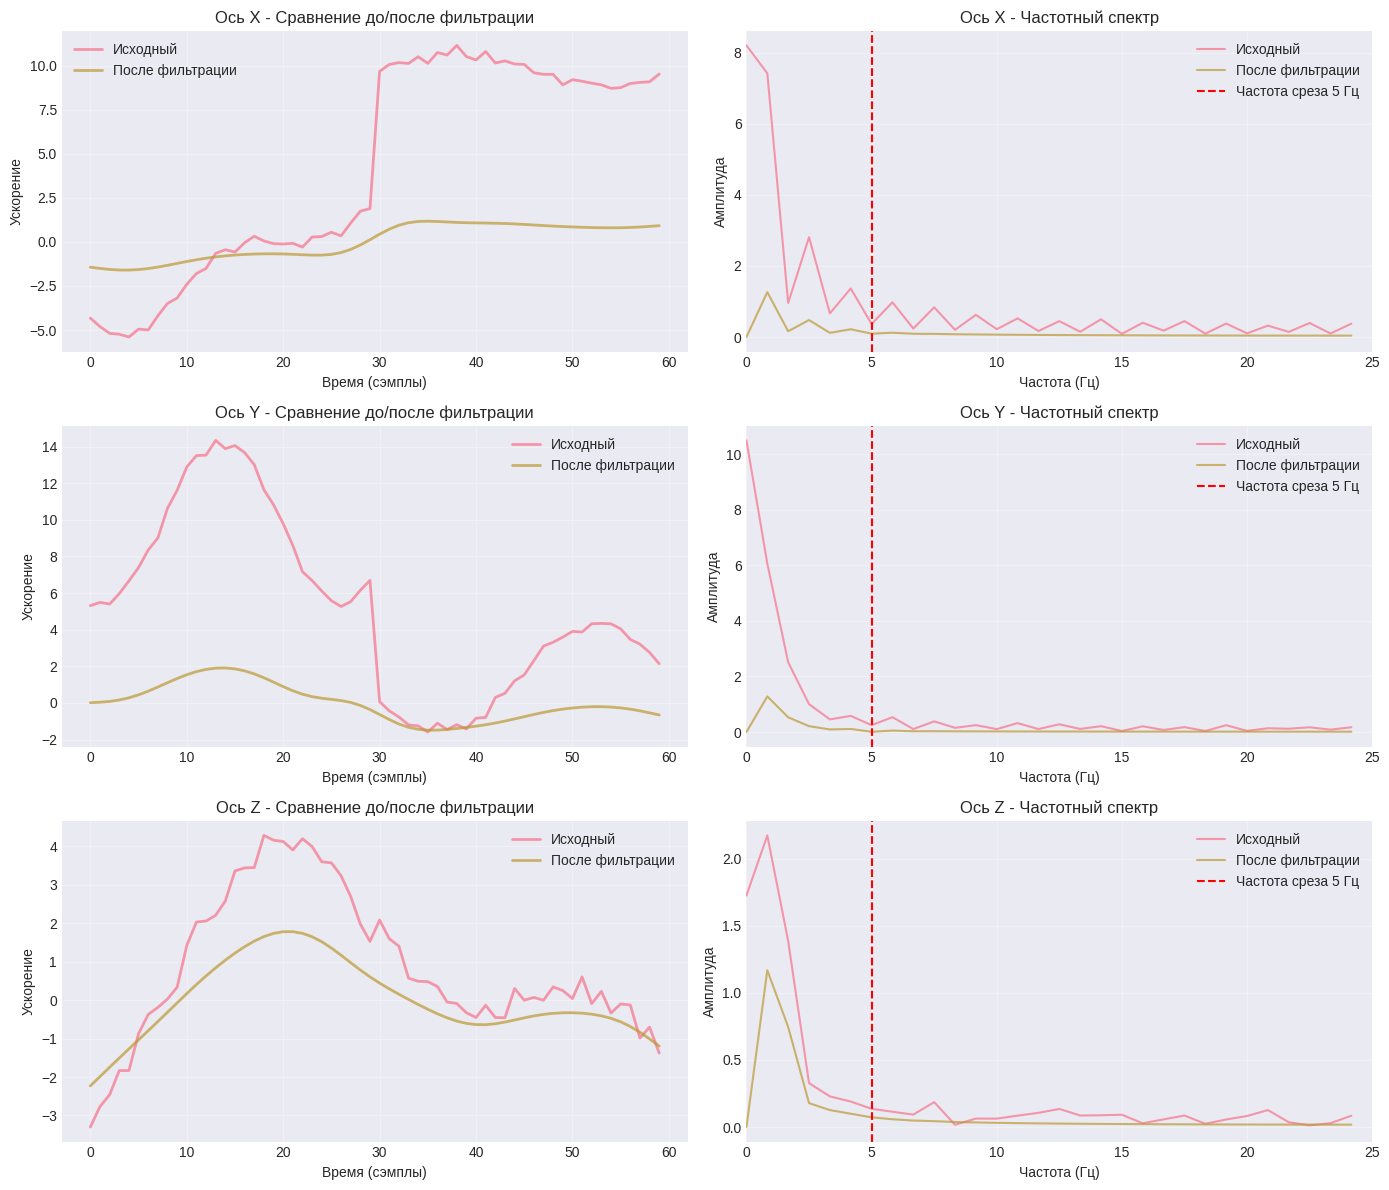

In [ ]:
# визуализация эффекта фильтрации
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
sample_window_idx = np.random.randint(0, len(X_windows))

for axis_idx, axis_name in enumerate(['X', 'Y', 'Z']):
    # до фильтрации
    axes[axis_idx, 0].plot(X_windows[sample_window_idx][:, axis_idx],
                          label='Исходный', alpha=0.7, linewidth=2)
    axes[axis_idx, 0].plot(X_filtered[sample_window_idx][:, axis_idx],
                          label='После фильтрации', alpha=0.7, linewidth=2)
    axes[axis_idx, 0].set_title(f'Ось {axis_name} - Сравнение до/после фильтрации')
    axes[axis_idx, 0].set_xlabel('Время (сэмплы)')
    axes[axis_idx, 0].set_ylabel('Ускорение')
    axes[axis_idx, 0].legend()
    axes[axis_idx, 0].grid(True, alpha=0.3)

    # частотный спектр
    from scipy.fft import fft, fftfreq
    N = len(X_windows[sample_window_idx][:, axis_idx])
    T = 1/50.0

    # исходный сигнал
    yf_original = fft(X_windows[sample_window_idx][:, axis_idx])
    xf_original = fftfreq(N, T)[:N//2]

    # отфильтрованный сигнал
    yf_filtered = fft(X_filtered[sample_window_idx][:, axis_idx])

    axes[axis_idx, 1].plot(xf_original, 2.0/N * np.abs(yf_original[0:N//2]),
                          label='Исходный', alpha=0.7)
    axes[axis_idx, 1].plot(xf_original, 2.0/N * np.abs(yf_filtered[0:N//2]),
                          label='После фильтрации', alpha=0.7)
    axes[axis_idx, 1].axvline(5, color='red', linestyle='--', label='Частота среза 5 Гц')
    axes[axis_idx, 1].set_title(f'Ось {axis_name} - Частотный спектр')
    axes[axis_idx, 1].set_xlabel('Частота (Гц)')
    axes[axis_idx, 1].set_ylabel('Амплитуда')
    axes[axis_idx, 1].legend()
    axes[axis_idx, 1].grid(True, alpha=0.3)
    axes[axis_idx, 1].set_xlim([0, 25])

plt.tight_layout()
plt.show()

## Аугментации

In [ ]:
def augment_data(windows, labels, augment_factor=0.3):
    """
    Создает дополнительные данные для увеличения разнообразия
    """
    augmented_windows = []
    augmented_labels = []

    for window, label in zip(windows, labels):
        augmented_windows.append(window)
        augmented_labels.append(label)

        # случайный шум
        if label != 0 and np.random.random() < augment_factor:
            noise = np.random.normal(0, 0.05, window.shape)
            augmented_windows.append(window + noise)
            augmented_labels.append(label)

        # временной сдвиг
        if label != 0 and np.random.random() < augment_factor:
            shift = np.random.randint(-5, 6)
            shifted = np.roll(window, shift, axis=0)

            if shift > 0:
                shifted[:shift, :] = 0
            elif shift < 0:
                shifted[shift:, :] = 0
            augmented_windows.append(shifted)
            augmented_labels.append(label)

        # масштабирование амплитуды
        if label != 0 and np.random.random() < augment_factor:
            scale = np.random.uniform(0.8, 1.2)
            scaled = window * scale
            augmented_windows.append(scaled)
            augmented_labels.append(label)

    return np.array(augmented_windows), np.array(augmented_labels)

## Выделение признаков

In [ ]:
def extract_features(windows):
    """
    Извлекает важные признаки из временных окон
    """
    features_list = []

    for window in windows:
        features = []

        for axis in range(3):
            data = window[:, axis]

            # статистические признаки
            features.extend([
                np.mean(data),           # среднее значение
                np.std(data),            # стандартное отклонение
                np.max(data),            # максимум
                np.min(data),            # минимум
                np.ptp(data),            # мазмах
                np.median(data),         # медиана
                np.var(data),            # дисперсия
                np.mean(np.abs(data)),   # среднее абсолютное значение
            ])

            # признаки, основанные на энергии
            features.extend([
                np.sum(data**2),            # энергия сигнала
                np.mean(np.diff(data)**2),  # энергия производной
            ])

            # частотные признаки
            fft_vals = np.abs(np.fft.fft(data))[:len(data)//2]
            if len(fft_vals) > 0:
                features.extend([
                    np.max(fft_vals),        # максимальная амплитуда в частотной области
                    np.mean(fft_vals[:5]),   # средняя амплитуда низких частот
                    np.sum(fft_vals[5:10]),  # энергия средних частот
                ])

        # признаки, основанные на взаимосвязи осей
        # корреляция между осями
        corr_xy = np.corrcoef(window[:, 0], window[:, 1])[0, 1]
        corr_xz = np.corrcoef(window[:, 0], window[:, 2])[0, 1]
        corr_yz = np.corrcoef(window[:, 1], window[:, 2])[0, 1]
        features.extend([corr_xy, corr_xz, corr_yz])

        # магнитуда ускорения
        magnitude = np.sqrt(window[:, 0]**2 + window[:, 1]**2 + window[:, 2]**2)
        features.extend([
            np.mean(magnitude),
            np.std(magnitude),
            np.max(magnitude),
            np.min(magnitude)
        ])

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# извлечение признаков
X_features = extract_features(X_filtered)

In [ ]:
print(f"Размерность признакового пространства: {X_features.shape}")
print(f"Количество признаков на окно: {X_features.shape[1]}")

Размерность признакового пространства: (1194, 46)
Количество признаков на окно: 46


In [ ]:
# нормализуем признаки
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

## Разделение данных

In [ ]:
X_windows_final = X_filtered
y_windows_final = y_windows

In [ ]:
X_train_w, X_temp_w, y_train_w, y_temp_w = train_test_split(
    X_windows_final, y_windows_final,
    test_size=0.3,
    random_state=42,
    stratify=y_windows_final
)

In [ ]:
X_val_w, X_test_w, y_val_w, y_test_w = train_test_split(
    X_temp_w, y_temp_w,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_w
)

In [ ]:
# аугментация тренировочных данных
X_train_augmented, y_train_augmented = augment_data(X_train_w, y_train_w, augment_factor=0.3)

In [ ]:
print("Разделение данных для моделей для окон:")
print(f"Train: {X_train_augmented.shape} ({len(X_train_augmented)/len(X_windows_final)*100:.1f}%)")
print(f"Validation: {X_val_w.shape} ({len(X_val_w)/len(X_windows_final)*100:.1f}%)")
print(f"Test: {X_test_w.shape} ({len(X_test_w)/len(X_windows_final)*100:.1f}%)")

Разделение данных для моделей для окон:
Train: (1476, 60, 3) (123.6%)
Validation: (179, 60, 3) (15.0%)
Test: (180, 60, 3) (15.1%)


In [ ]:
print("\nРаспределение классов в тренировочном наборе:")
unique_train, counts_train = np.unique(y_train_augmented, return_counts=True)
for gesture_id, count in zip(unique_train, counts_train):
    print(f"Жест {gesture_id}: {count} окон ({count/len(y_train_augmented)*100:.1f}%)")


Распределение классов в тренировочном наборе:
Жест 0: 140 окон (9.5%)
Жест 1: 266 окон (18.0%)
Жест 2: 284 окон (19.2%)
Жест 3: 258 окон (17.5%)
Жест 4: 261 окон (17.7%)
Жест 5: 267 окон (18.1%)


## Визуализация разделения классов

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_features_scaled[:1000])

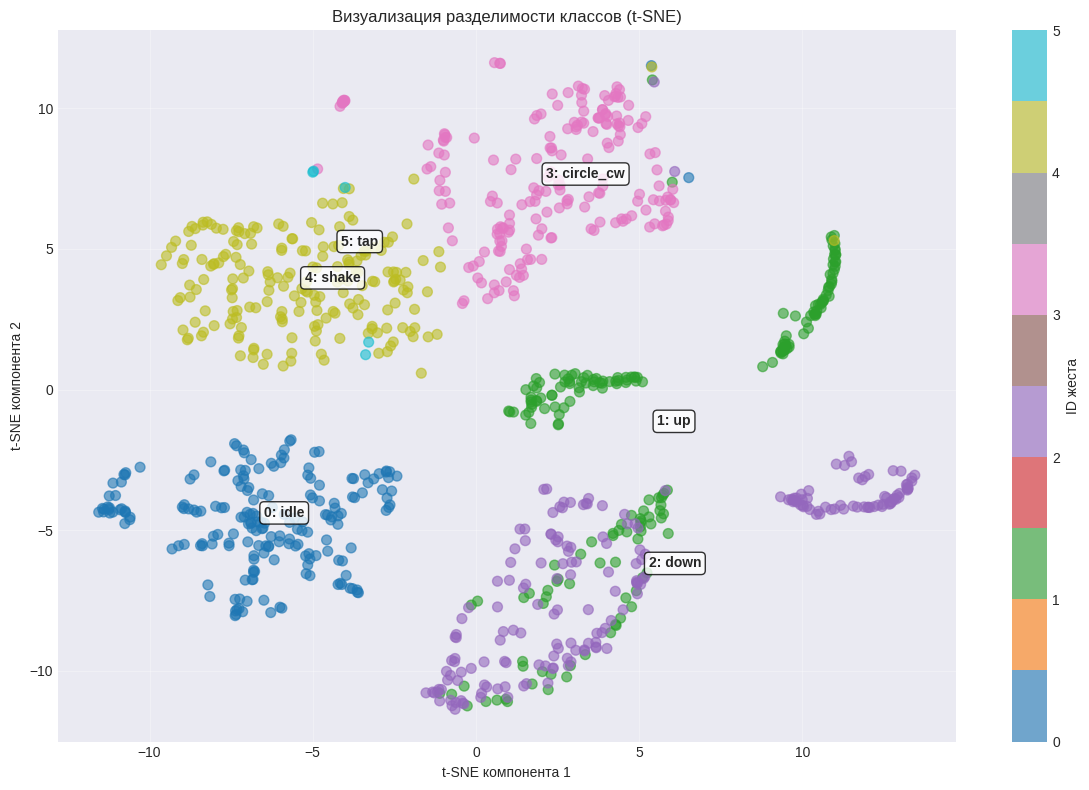

In [ ]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                      c=y_windows[:1000],
                      cmap='tab10',
                      alpha=0.6,
                      s=50)

plt.colorbar(scatter, label='ID жеста')
plt.title('Визуализация разделимости классов (t-SNE)')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')

for gesture_id in range(6):
    mask = y_windows[:1000] == gesture_id
    if np.any(mask):
        center = X_tsne[mask].mean(axis=0)
        plt.annotate(f'{gesture_id}: {gesture_names[gesture_id].split()[0]}',
                     center, fontsize=10, fontweight='bold',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Сохранение данных

In [ ]:
np.savez_compressed('processed_gesture_data.npz',
                   X_train=X_train_augmented,
                   y_train=y_train_augmented,
                   X_val=X_val_w,
                   y_val=y_val_w,
                   X_test=X_test_w,
                   y_test=y_test_w,
                   X_features=X_features_scaled,
                   y_features=y_windows)

In [ ]:
# cохраняем метаданные
import json
metadata = {
    'window_size': WINDOW_SIZE,
    'overlap': OVERLAP,
    'sampling_rate': 50.0,
    'gesture_names': gesture_names,
    'feature_names': feature_names,
    'train_size': len(X_train_augmented),
    'val_size': len(X_val_w),
    'test_size': len(X_test_w),
    'total_windows': len(X_windows_final)
}

In [ ]:
with open('gesture_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

In [ ]:
print(f"Исходный датасет: {df.shape[0]} записей")
print(f"Создано окон: {len(X_windows_final)} окон по {WINDOW_SIZE} сэмплов")
print(f"После аугментации: {len(X_train_augmented) + len(X_val_w) + len(X_test_w)} окон")
print(f"\nРазмерности:")
print(f"X_train: {X_train_augmented.shape}")
print(f"X_val: {X_val_w.shape}")
print(f"X_test: {X_test_w.shape}")
print(f"Всего признаков: {X_features_scaled.shape[1]}")

Исходный датасет: 36000 записей
Создано окон: 1194 окон по 60 сэмплов
После аугментации: 1835 окон

Размерности:
X_train: (1476, 60, 3)
X_val: (179, 60, 3)
X_test: (180, 60, 3)
Всего признаков: 46


In [ ]:
print("\nБалансировка классов (тренировочный набор):")
for gesture_id in range(6):
    count = np.sum(y_train_augmented == gesture_id)
    if count > 0:
        percentage = count / len(y_train_augmented) * 100
        print(f"Жест {gesture_id}: {count:4d} окон ({percentage:5.1f}%)")


Балансировка классов (тренировочный набор):
Жест 0:  140 окон (  9.5%)
Жест 1:  266 окон ( 18.0%)
Жест 2:  284 окон ( 19.2%)
Жест 3:  258 окон ( 17.5%)
Жест 4:  261 окон ( 17.7%)
Жест 5:  267 окон ( 18.1%)
